In [2]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [3]:
torch.cuda.set_device(1)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

In [7]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

# 224

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [10]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [11]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00015848931798245758)

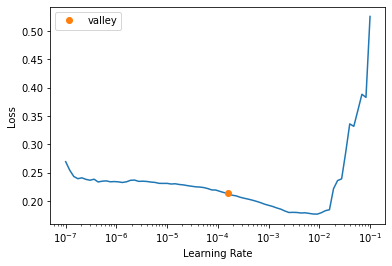

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.129649,6.937140,0.514103,0.612245,0.076923,0.136674,0.616193,01:55


Better model found at epoch 0 with f1_score value: 0.13667425968109342.


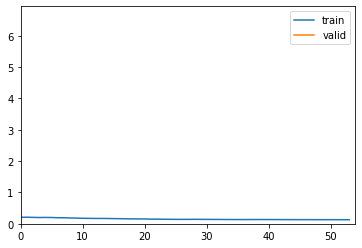

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.101269,0.088950,0.835897,0.885294,0.771795,0.824658,0.926654,01:57
1,0.091827,0.082018,0.861538,0.865285,0.856410,0.860825,0.941085,01:57
2,0.088336,0.083315,0.844872,0.858667,0.825641,0.841830,0.935634,01:57
3,0.085029,0.084246,0.848718,0.904762,0.779487,0.837466,0.944293,01:57
4,0.082735,0.089259,0.855128,0.931464,0.766667,0.841069,0.941732,01:57
5,0.081588,0.086691,0.852564,0.878788,0.817949,0.847278,0.935769,01:56
6,0.082261,0.083176,0.862821,0.861893,0.864103,0.862996,0.941594,01:55


Better model found at epoch 0 with f1_score value: 0.8246575342465753.


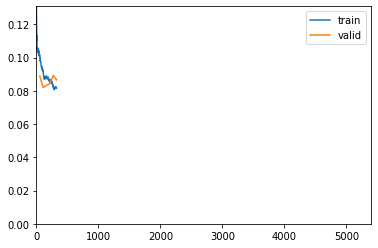

Better model found at epoch 1 with f1_score value: 0.8608247422680412.
Better model found at epoch 6 with f1_score value: 0.8629961587708066.
No improvement since epoch 1: early stopping


In [13]:
learn.fine_tune(100,base_lr=3e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9568783694937542.


(#6) [0.07316561043262482,0.8938461542129517,0.888663967611336,0.9005128205128206,0.8945491594498218,0.9568783694937542]

# 384

In [20]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest50d_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [21]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [22]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [23]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [24]:
learn.load('resnest_224_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003311311302240938)

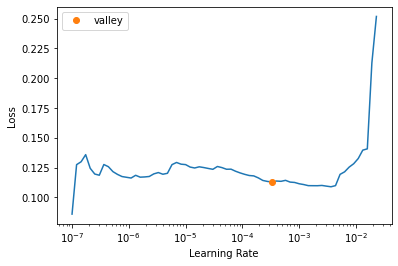

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.228236,0.273216,0.500000,0.500000,1.000000,0.666667,0.529379,02:48


Better model found at epoch 0 with f1_score value: 0.6666666666666666.


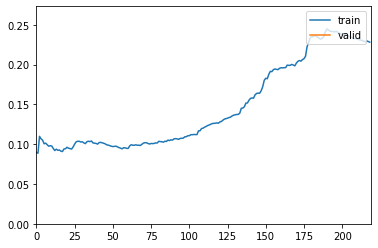

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.182687,0.169317,0.594872,0.583710,0.661538,0.620192,0.602817,02:48
1,0.174051,0.168937,0.597436,0.579167,0.712821,0.639080,0.624474,02:48
2,0.176639,0.168842,0.606410,0.618234,0.556410,0.585695,0.643156,02:49
3,0.170673,0.165905,0.602564,0.581301,0.733333,0.648526,0.628797,02:49
4,0.166826,0.168308,0.587179,0.591398,0.564103,0.577428,0.638008,02:48
5,0.161355,0.162476,0.623077,0.604348,0.712821,0.654118,0.684260,02:49
6,0.165367,0.160561,0.630769,0.642458,0.589744,0.614973,0.691164,02:48
7,0.162062,0.157005,0.650000,0.635104,0.705128,0.668287,0.710099,02:49
8,0.159313,0.157215,0.652564,0.653747,0.648718,0.651223,0.713790,02:49
9,0.156913,0.157631,0.638462,0.585987,0.943590,0.722986,0.731637,02:50


Better model found at epoch 0 with f1_score value: 0.6201923076923077.


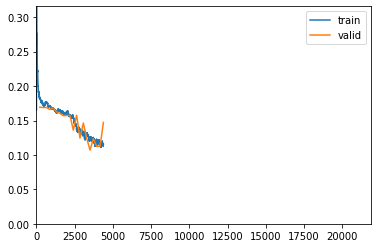

Better model found at epoch 1 with f1_score value: 0.639080459770115.
Better model found at epoch 3 with f1_score value: 0.6485260770975056.
Better model found at epoch 5 with f1_score value: 0.6541176470588235.
Better model found at epoch 7 with f1_score value: 0.6682867557715674.
Better model found at epoch 9 with f1_score value: 0.7229862475442043.
Better model found at epoch 10 with f1_score value: 0.7427884615384613.
Better model found at epoch 12 with f1_score value: 0.782082324455206.
Better model found at epoch 14 with f1_score value: 0.7866831072749693.
Better model found at epoch 15 with f1_score value: 0.8149038461538463.
No improvement since epoch 15: early stopping


In [26]:
learn.fine_tune(100,base_lr=3e-3)

In [27]:
dfTest = pd.read_csv('../testSample.csv')

In [28]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [30]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [31]:
learn.dls = dlsTest

In [32]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9147797501643655.


(#6) [0.09957621246576309,0.834871768951416,0.8166828322017459,0.8635897435897436,0.8394815553339979,0.9147797501643655]

# 512

In [33]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest50d_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [34]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [35]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [36]:
learn = Learner(dls,timm.create_model('resnest50d',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [37]:
learn.load('resnest50d_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.004365158267319202)

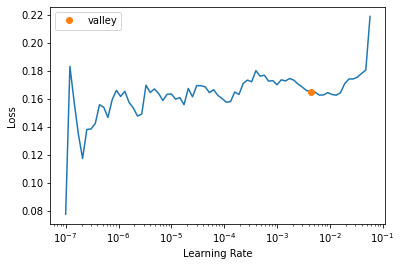

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.125690,0.111648,0.787179,0.847826,0.700000,0.766854,0.883241,05:26


Better model found at epoch 0 with f1_score value: 0.7668539325842696.


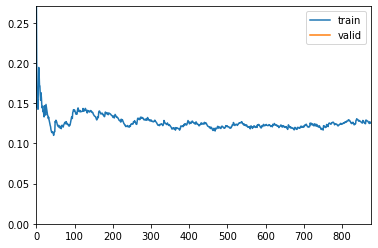

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.104164,0.092444,0.838462,0.892857,0.769231,0.826446,0.922364,05:27
1,0.092732,0.094908,0.829487,0.874636,0.769231,0.818554,0.913843,05:27
2,0.100511,0.093100,0.833333,0.882353,0.769231,0.821918,0.917304,05:30
3,0.102829,0.093747,0.825641,0.889571,0.743590,0.810056,0.918915,05:35
4,0.093404,0.093951,0.821795,0.874627,0.751282,0.808276,0.914609,05:30
5,0.093299,0.091388,0.833333,0.826633,0.843590,0.835025,0.924632,05:27
6,0.102110,0.083274,0.843590,0.870166,0.807692,0.837766,0.932751,05:28
7,0.101273,0.093084,0.833333,0.914013,0.735897,0.815341,0.924132,05:29
8,0.100464,0.095691,0.837179,0.852547,0.815385,0.833552,0.917278,05:35
9,0.093657,0.091056,0.832051,0.860724,0.792308,0.825100,0.923777,05:35


Better model found at epoch 0 with f1_score value: 0.8264462809917357.


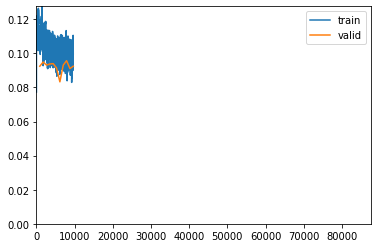

Better model found at epoch 5 with f1_score value: 0.8350253807106599.
Better model found at epoch 6 with f1_score value: 0.8377659574468085.
No improvement since epoch 6: early stopping


In [39]:
learn.fine_tune(100,base_lr=1e-3)

In [40]:
dfTest = pd.read_csv('../testSample.csv')

In [41]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [43]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [44]:
learn.dls = dlsTest

In [45]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9488336620644313.


(#6) [0.07886258512735367,0.890256404876709,0.9017951425554382,0.8758974358974358,0.8886576482830384,0.9488336620644313]